# LSTM test module for temporal data prediction

In [1]:
# General import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# ML Model import 
from keras.models import Sequential # for initializing neural network
from keras.layers import Dense, LSTM, Dropout 
# Dense = for adding densely connected neural network layer
# LSTM = for adding Long Short-Term Memory Layer
# Dropout = for adding dropout layers that prevent overfitting (somekind of regularization)

#Data Cleaning, PreProcessing, and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/tmp/ipykernel_303454/3389234248.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-10 06:27:48.321545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dev Zone 

In [21]:
# Build LSTM Cell
def build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type,loss_type):
    """

    Typical Values
    n_units = 50
    dropout_rate = 0.2
    n_dense = 1
    n_epochs = 100
    n_batch = 32
    opt_type = 'adam'
    loss_type = 'mean_squared_error'
    """
    # Constructing our LSTM Layer
    
    #initialize NN
    regressor = Sequential()
    
    # 50 is dimensionality of output space, True is return last output (full sequence), 0.2 = 20% dropped randomly
    # Dropout help with minimizing overfitting
    regressor.add(LSTM(units=n_units, return_sequences = True, input_shape = (x_train.shape[1],1)))
    regressor.add(Dropout(dropout_rate))

    # Stack more layers [Check influence of LSTM layer depth]
    if LSTM_depth == 2:
        regressor.add(LSTM(units = n_units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
    
    elif LSTM_depth == 3:
        regressor.add(LSTM(units = n_units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
        
        regressor.add(LSTM(units = n_units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
    
    elif LSTM_depth == 4:
        regressor.add(LSTM(units = n_units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
    
        regressor.add(LSTM(units = n_units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
        
        regressor.add(LSTM(units = n_units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
    
    else: 
        print("please specify LSTM depth between 2-4")
    #no need to return sequence here because only final output is needed for Dense Layer
    regressor.add(LSTM(units = n_units))
    regressor.add(Dropout(dropout_rate))
    
    #Dense Layer for regression prediction
    regressor.add(Dense(units = n_dense))
    
    # Specifying Loss Function for optimization
    regressor.compile(optimizer = opt_type, loss = loss_type)
    
    # Define batch size and training durations.
    regressor.fit(x_train, y_train, epochs = n_epochs, batch_size = n_batch)

    return regressor

In [15]:
def prepare_training_data(training_set_scaled, window_size):

    """
    return x_train, y_train
    """
    x_train = []
    y_train = []
    # in list form
    data_length = len(training_set_scaled)
    for i in range(window_size,data_length):
        x_train.append(training_set_scaled[i-window_size:i,0])
        y_train.append(training_set_scaled[i,0])

    #make into array
    x_train, y_train = np.array(x_train), np.array(y_train)
    # Reshape into 3D array
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    return x_train, y_train
    

In [24]:
def prepare_test_data(inputs, scaling, window_size, test_data_length):
    inputs = scaling.transform(inputs)
    x_test = []
    for i in range(window_size,window_size + test_data_length):
        x_test.append(inputs[i-window_size:i,0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    return x_test

def get_prediction(my_regressor, x_test, scaling):   
    prediction = my_regressor.predict(x_test)
    prediction = scaling.inverse_transform(prediction)
    return prediction

#Evaluate Performance
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test,predicted))
    print(f"The root mean squared error is {rmse}.")
    return rmse

# Section I : Single Run with Default Parameters for LSTM

## STEPS:
1. Load Training and Test Data Set, Build Combined Dataset
2. Scale the training data 
3. Build the LSTM model regressor
4. Preprocess test data
5. Test model performance. 

## 1. Load Training and Test Data Set, Build Combined Dataset

In [6]:
# load dataset
dataset_train = pd.read_csv('NSE-TATAGLOBAL.csv')
training_set = dataset_train.iloc[:,1:2].values # dataset_train['Open'].values need to reshape for this case.

In [7]:
# upload test dataset
dataset_test = pd.read_csv('tatatest.csv')
real_stock_price = dataset_test.iloc[:,1:2].values

In [8]:
# prepared combined data set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

## 2. Scale & Prepare training Data 

In [9]:
# Data need to be scaled for optimal performance
# rescale training data 
scaling = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaling.fit_transform(training_set)

In [16]:
window_size = 60
x_train, y_train = prepare_training_data(training_set_scaled, window_size)

## 3. Build the LSTM model regressor

In [22]:
n_units = 50
dropout_rate = 0.2
n_dense = 1
n_epochs = 100
n_batch = 32
LSTM_depth = 3
regressor = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 10s 64ms/step - loss: 0.0083
Epoch 2/100
62/62 [==============================] - 4s 65ms/step - loss: 0.0031
Epoch 3/100
62/62 [==============================] - 4s 66ms/step - loss: 0.0029
Epoch 4/100
62/62 [==============================] - 4s 65ms/step - loss: 0.0027
Epoch 5/100
62/62 [==============================] - 4s 65ms/step - loss: 0.0024
Epoch 6/100
62/62 [==============================] - 4s 65ms/step - loss: 0.0022
Epoch 7/100
62/62 [==============================] - 4s 64ms/step - loss: 0.0019
Epoch 8/100
62/62 [==============================] - 6s 91ms/step - loss: 0.0020
Epoch 9/100
62/62 [==============================] - 10s 167ms/step - loss: 0.0019
Epoch 10/100
62/62 [==============================] - 9s 138ms/step - loss: 0.0018
Epoch 11/100
62/62 [==============================] - 5s 84ms/step - loss: 0.0022
Epoch 12/100
62/62 [==============================] - 5s 79ms/step - loss: 0.0017
Epoch 13/100
62/62 [=

## 4. Preprocess test data

In [26]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - window_size:].values
inputs = inputs.reshape(-1,1)
test_data_length = len(dataset_test)
x_test = prepare_test_data(inputs, scaling, window_size, test_data_length)

## 5. Test Model Performance

In [27]:
# use regressor to do the prediction. 
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = scaling.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 1s/step


In [28]:
rmse = return_rmse(real_stock_price,predicted_stock_price)

The root mean squared error is 27.0759442105617.


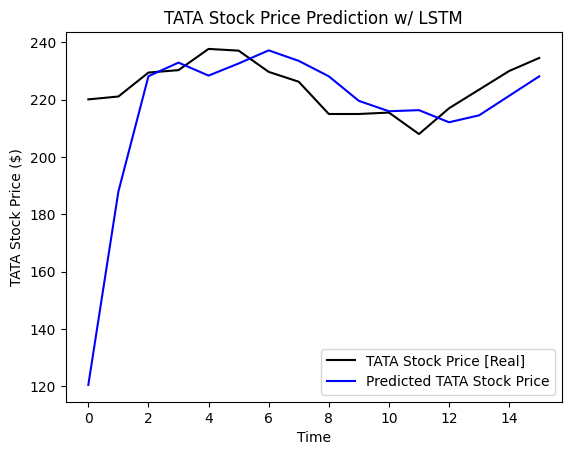

In [29]:
# Plot Results
plt.plot(real_stock_price, color = 'k', label='TATA Stock Price [Real] ')
plt.plot(predicted_stock_price, color = 'b', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction w/ LSTM')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price ($)')
plt.legend()
plt.show();

--- This Section Ends Here ---

# Section II : Batch processed test to be submitted for various cases. 

In [ ]:
Goal: Improve performance for this particular model to a range of < 5% error margin

In [9]:
#do create regressor with different parameters

In [31]:
#Regressor 2  # Effect of N_epochs
n_units = 50
dropout_rate = 0.2
n_dense = 1
n_epochs = 50
n_batch = 32
LSTM_depth = 3
regressor_2 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')


Epoch 1/50
62/62 [==============================] - 10s 66ms/step - loss: 0.0109
Epoch 2/50
62/62 [==============================] - 4s 67ms/step - loss: 0.0032
Epoch 3/50
62/62 [==============================] - 4s 63ms/step - loss: 0.0028
Epoch 4/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0027
Epoch 5/50
62/62 [==============================] - 4s 63ms/step - loss: 0.0027
Epoch 6/50
62/62 [==============================] - 4s 63ms/step - loss: 0.0025
Epoch 7/50
62/62 [==============================] - 4s 65ms/step - loss: 0.0023
Epoch 8/50
62/62 [==============================] - 4s 67ms/step - loss: 0.0021
Epoch 9/50
62/62 [==============================] - 4s 68ms/step - loss: 0.0019
Epoch 10/50
62/62 [==============================] - 4s 68ms/step - loss: 0.0019
Epoch 11/50
62/62 [==============================] - 4s 65ms/step - loss: 0.0018
Epoch 12/50
62/62 [==============================] - 4s 65ms/step - loss: 0.0017
Epoch 13/50
62/62 [=================

In [32]:
# effect of n_units
n_units = 80 
dropout_rate = 0.2
n_dense = 1
n_epochs = 50
n_batch = 32
LSTM_depth = 3
regressor_3 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/50
62/62 [==============================] - 11s 80ms/step - loss: 0.0065
Epoch 2/50
62/62 [==============================] - 5s 79ms/step - loss: 0.0030
Epoch 3/50
62/62 [==============================] - 5s 79ms/step - loss: 0.0024
Epoch 4/50
62/62 [==============================] - 5s 88ms/step - loss: 0.0022
Epoch 5/50
62/62 [==============================] - 5s 76ms/step - loss: 0.0020
Epoch 6/50
62/62 [==============================] - 5s 77ms/step - loss: 0.0024
Epoch 7/50
62/62 [==============================] - 5s 75ms/step - loss: 0.0016
Epoch 8/50
62/62 [==============================] - 5s 75ms/step - loss: 0.0018
Epoch 9/50
62/62 [==============================] - 5s 75ms/step - loss: 0.0015
Epoch 10/50
62/62 [==============================] - 5s 80ms/step - loss: 0.0016
Epoch 11/50
62/62 [==============================] - 5s 78ms/step - loss: 0.0017
Epoch 12/50
62/62 [==============================] - 5s 81ms/step - loss: 0.0014
Epoch 13/50
62/62 [=================

In [38]:
# Model 4 : effect of dropout_rate
n_units = 50 
dropout_rate = 0.1
n_dense = 1
n_epochs = 50
n_batch = 32
LSTM_depth = 3
regressor_4 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/50
62/62 [==============================] - 10s 58ms/step - loss: 0.0085
Epoch 2/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0026
Epoch 3/50
62/62 [==============================] - 4s 62ms/step - loss: 0.0024
Epoch 4/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0019
Epoch 5/50
62/62 [==============================] - 4s 64ms/step - loss: 0.0018
Epoch 6/50
62/62 [==============================] - 4s 65ms/step - loss: 0.0021
Epoch 7/50
62/62 [==============================] - 4s 64ms/step - loss: 0.0018
Epoch 8/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0017
Epoch 9/50
62/62 [==============================] - 4s 67ms/step - loss: 0.0016
Epoch 10/50
62/62 [==============================] - 4s 65ms/step - loss: 0.0015
Epoch 11/50
62/62 [==============================] - 4s 64ms/step - loss: 0.0015
Epoch 12/50
62/62 [==============================] - 4s 64ms/step - loss: 0.0016
Epoch 13/50
62/62 [=================

In [39]:
# Model 5 : effect of LSTM layer
n_units = 50 
dropout_rate = 0.2
n_dense = 1
n_epochs = 50
n_batch = 32
LSTM_depth = 4
regressor_5 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/50
62/62 [==============================] - 12s 74ms/step - loss: 0.0094
Epoch 2/50
62/62 [==============================] - 5s 77ms/step - loss: 0.0037
Epoch 3/50
62/62 [==============================] - 5s 85ms/step - loss: 0.0028
Epoch 4/50
62/62 [==============================] - 5s 88ms/step - loss: 0.0034
Epoch 5/50
62/62 [==============================] - 5s 76ms/step - loss: 0.0027
Epoch 6/50
62/62 [==============================] - 5s 77ms/step - loss: 0.0031
Epoch 7/50
62/62 [==============================] - 5s 79ms/step - loss: 0.0024
Epoch 8/50
62/62 [==============================] - 5s 76ms/step - loss: 0.0024
Epoch 9/50
62/62 [==============================] - 5s 83ms/step - loss: 0.0022
Epoch 10/50
62/62 [==============================] - 5s 84ms/step - loss: 0.0022
Epoch 11/50
62/62 [==============================] - 5s 82ms/step - loss: 0.0021
Epoch 12/50
62/62 [==============================] - 5s 78ms/step - loss: 0.0020
Epoch 13/50
62/62 [=================

In [43]:
# Model 6 effect of n_units with 100epochs
n_units = 80 
dropout_rate = 0.2
n_dense = 1
n_epochs = 100
n_batch = 32
LSTM_depth = 3
regressor_6 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 12s 95ms/step - loss: 0.0100
Epoch 2/100
62/62 [==============================] - 6s 90ms/step - loss: 0.0027
Epoch 3/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0027
Epoch 4/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0020
Epoch 5/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0019
Epoch 6/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0019
Epoch 7/100
62/62 [==============================] - 7s 113ms/step - loss: 0.0020
Epoch 8/100
62/62 [==============================] - 5s 85ms/step - loss: 0.0015
Epoch 9/100
62/62 [==============================] - 5s 79ms/step - loss: 0.0016
Epoch 10/100
62/62 [==============================] - 5s 73ms/step - loss: 0.0015
Epoch 11/100
62/62 [==============================] - 5s 79ms/step - loss: 0.0016
Epoch 12/100
62/62 [==============================] - 5s 76ms/step - loss: 0.0015
Epoch 13/100
62/62 [===

In [44]:
# Model 7 effect of n_units with 100epochs and more dropout rate
n_units = 80 
dropout_rate = 0.3
n_dense = 1
n_epochs = 100
n_batch = 32
LSTM_depth = 3
regressor_7 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 11s 84ms/step - loss: 0.0107
Epoch 2/100
62/62 [==============================] - 5s 74ms/step - loss: 0.0035
Epoch 3/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0036
Epoch 4/100
62/62 [==============================] - 5s 78ms/step - loss: 0.0025
Epoch 5/100
62/62 [==============================] - 5s 86ms/step - loss: 0.0025
Epoch 6/100
62/62 [==============================] - 5s 87ms/step - loss: 0.0023
Epoch 7/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0023
Epoch 8/100
62/62 [==============================] - 5s 82ms/step - loss: 0.0021
Epoch 9/100
62/62 [==============================] - 5s 86ms/step - loss: 0.0021
Epoch 10/100
62/62 [==============================] - 6s 103ms/step - loss: 0.0021
Epoch 11/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0019
Epoch 12/100
62/62 [==============================] - 5s 77ms/step - loss: 0.0017
Epoch 13/100
62/62 [===

In [49]:
# Model 8 effect of n_units with 100epochs less dropout
n_units = 80 
dropout_rate = 0.1
n_dense = 1
n_epochs = 100
n_batch = 32
LSTM_depth = 3
regressor_8 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 11s 79ms/step - loss: 0.0079
Epoch 2/100
62/62 [==============================] - 5s 75ms/step - loss: 0.0023
Epoch 3/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0018
Epoch 4/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0018
Epoch 5/100
62/62 [==============================] - 4s 72ms/step - loss: 0.0019
Epoch 6/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0018
Epoch 7/100
62/62 [==============================] - 5s 80ms/step - loss: 0.0014
Epoch 8/100
62/62 [==============================] - 5s 88ms/step - loss: 0.0020
Epoch 9/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0013
Epoch 10/100
62/62 [==============================] - 7s 110ms/step - loss: 0.0014
Epoch 11/100
62/62 [==============================] - 6s 93ms/step - loss: 0.0012
Epoch 12/100
62/62 [==============================] - 5s 82ms/step - loss: 0.0012
Epoch 13/100
62/62 [===

In [50]:
# Model 9 effect of n_units with 100epochs more depth
n_units = 80 
dropout_rate = 0.2
n_dense = 1
n_epochs = 100
n_batch = 32
LSTM_depth = 4
regressor_9 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 14s 101ms/step - loss: 0.0144
Epoch 2/100
62/62 [==============================] - 6s 102ms/step - loss: 0.0029
Epoch 3/100
62/62 [==============================] - 7s 108ms/step - loss: 0.0030
Epoch 4/100
62/62 [==============================] - 6s 101ms/step - loss: 0.0027
Epoch 5/100
62/62 [==============================] - 7s 113ms/step - loss: 0.0023
Epoch 6/100
62/62 [==============================] - 7s 110ms/step - loss: 0.0023
Epoch 7/100
62/62 [==============================] - 6s 101ms/step - loss: 0.0029
Epoch 8/100
62/62 [==============================] - 6s 95ms/step - loss: 0.0019
Epoch 9/100
62/62 [==============================] - 6s 104ms/step - loss: 0.0021
Epoch 10/100
62/62 [==============================] - 6s 99ms/step - loss: 0.0020
Epoch 11/100
62/62 [==============================] - 6s 100ms/step - loss: 0.0020
Epoch 12/100
62/62 [==============================] - 6s 98ms/step - loss: 0.0022
Epoch 13/100
62

In [51]:
# Model 10 more dense
n_units = 50 
dropout_rate = 0.2
n_dense = 3
n_epochs = 100
n_batch = 32
LSTM_depth = 4
regressor_10 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 14s 91ms/step - loss: 0.0133
Epoch 2/100
62/62 [==============================] - 5s 86ms/step - loss: 0.0044
Epoch 3/100
62/62 [==============================] - 6s 96ms/step - loss: 0.0044
Epoch 4/100
62/62 [==============================] - 6s 92ms/step - loss: 0.0038
Epoch 5/100
62/62 [==============================] - 5s 86ms/step - loss: 0.0039
Epoch 6/100
62/62 [==============================] - 5s 79ms/step - loss: 0.0031
Epoch 7/100
62/62 [==============================] - 6s 90ms/step - loss: 0.0029
Epoch 8/100
62/62 [==============================] - 5s 87ms/step - loss: 0.0027
Epoch 9/100
62/62 [==============================] - 5s 85ms/step - loss: 0.0026
Epoch 10/100
62/62 [==============================] - 5s 89ms/step - loss: 0.0025
Epoch 11/100
62/62 [==============================] - 6s 104ms/step - loss: 0.0023
Epoch 12/100
62/62 [==============================] - 6s 90ms/step - loss: 0.0023
Epoch 13/100
62/62 [===

In [58]:
# Model 11 Model 8 with more batch
n_units = 80 
dropout_rate = 0.2
n_dense = 1
n_epochs = 100
n_batch = 64
LSTM_depth = 4
regressor_11 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
31/31 [==============================] - 17s 245ms/step - loss: 0.0213
Epoch 2/100
31/31 [==============================] - 7s 240ms/step - loss: 0.0033
Epoch 3/100
31/31 [==============================] - 7s 234ms/step - loss: 0.0028
Epoch 4/100
31/31 [==============================] - 8s 261ms/step - loss: 0.0028
Epoch 5/100
31/31 [==============================] - 8s 263ms/step - loss: 0.0026
Epoch 6/100
31/31 [==============================] - 7s 240ms/step - loss: 0.0024
Epoch 7/100
31/31 [==============================] - 7s 230ms/step - loss: 0.0023
Epoch 8/100
31/31 [==============================] - 7s 242ms/step - loss: 0.0021
Epoch 9/100
31/31 [==============================] - 7s 214ms/step - loss: 0.0021
Epoch 10/100
31/31 [==============================] - 7s 215ms/step - loss: 0.0021
Epoch 11/100
31/31 [==============================] - 6s 208ms/step - loss: 0.0025
Epoch 12/100
31/31 [==============================] - 7s 214ms/step - loss: 0.0019
Epoch 13/100

In [59]:
# Model 12= Model 8 with way more units and dropout
n_units = 100 
dropout_rate = 0.4
n_dense = 1
n_epochs = 100
n_batch = 32
LSTM_depth = 4
regressor_12 = build_LSTM(x_train,n_units, dropout_rate, n_dense, n_epochs, n_batch, LSTM_depth,
               opt_type='adam',loss_type='mean_squared_error')

Epoch 1/100
62/62 [==============================] - 18s 146ms/step - loss: 0.0095
Epoch 2/100
62/62 [==============================] - 8s 134ms/step - loss: 0.0041
Epoch 3/100
62/62 [==============================] - 8s 123ms/step - loss: 0.0036
Epoch 4/100
62/62 [==============================] - 8s 126ms/step - loss: 0.0043
Epoch 5/100
62/62 [==============================] - 8s 132ms/step - loss: 0.0034
Epoch 6/100
62/62 [==============================] - 8s 124ms/step - loss: 0.0033
Epoch 7/100
62/62 [==============================] - 8s 123ms/step - loss: 0.0024
Epoch 8/100
62/62 [==============================] - 8s 129ms/step - loss: 0.0028
Epoch 9/100
62/62 [==============================] - 8s 134ms/step - loss: 0.0027
Epoch 10/100
62/62 [==============================] - 8s 123ms/step - loss: 0.0024
Epoch 11/100
62/62 [==============================] - 8s 134ms/step - loss: 0.0024
Epoch 12/100
62/62 [==============================] - 8s 124ms/step - loss: 0.0028
Epoch 13/100

In [35]:
## Comparison between 3 models
my_regressor = regressor_2
predicted_stock_2 = get_prediction(my_regressor, x_test, scaling)

my_regressor = regressor_3
predicted_stock_3 = get_prediction(my_regressor, x_test, scaling)

1/1 [==============================] - 1s 1s/step


In [40]:
## Comparison between 3 models
my_regressor = regressor_4
predicted_stock_4 = get_prediction(my_regressor, x_test, scaling)

my_regressor = regressor_5
predicted_stock_5 = get_prediction(my_regressor, x_test, scaling)

1/1 [==============================] - 2s 2s/step


In [45]:
## Comparison between 3 models
my_regressor = regressor_6
predicted_stock_6 = get_prediction(my_regressor, x_test, scaling)

my_regressor = regressor_7
predicted_stock_7 = get_prediction(my_regressor, x_test, scaling)

1/1 [==============================] - 1s 1s/step


In [52]:

my_regressor = regressor_8
predicted_stock_8 = get_prediction(my_regressor, x_test, scaling)

my_regressor = regressor_9
predicted_stock_9 = get_prediction(my_regressor, x_test, scaling)

my_regressor = regressor_10
predicted_stock_10 = get_prediction(my_regressor, x_test, scaling)

1/1 [==============================] - 2s 2s/step


In [60]:

my_regressor = regressor_11
predicted_stock_11 = get_prediction(my_regressor, x_test, scaling)

my_regressor = regressor_12
predicted_stock_12 = get_prediction(my_regressor, x_test, scaling)

1/1 [==============================] - 2s 2s/step


In [37]:
rmse_2 = return_rmse(real_stock_price,predicted_stock_2)
rmse_3 = return_rmse(real_stock_price,predicted_stock_3)

The root mean squared error is 36.97150222748193.
The root mean squared error is 30.494399170843543.


In [41]:
rmse_4 = return_rmse(real_stock_price,predicted_stock_4)
rmse_5 = return_rmse(real_stock_price,predicted_stock_5)

The root mean squared error is 33.736995185018266.
The root mean squared error is 38.45542087933449.


In [46]:
rmse_6 = return_rmse(real_stock_price,predicted_stock_6)
rmse_7 = return_rmse(real_stock_price,predicted_stock_7)

The root mean squared error is 27.097368142819615.
The root mean squared error is 28.073761455296665.


In [53]:
rmse_8 = return_rmse(real_stock_price,predicted_stock_8)
rmse_9 = return_rmse(real_stock_price,predicted_stock_9)
rmse_10 = return_rmse(real_stock_price,predicted_stock_10)

The root mean squared error is 26.434695550468536.
The root mean squared error is 26.162842087205366.


ValueError: y_true and y_pred have different number of output (1!=3)

In [61]:
rmse_11 = return_rmse(real_stock_price,predicted_stock_11)
rmse_12 = return_rmse(real_stock_price,predicted_stock_12)

The root mean squared error is 31.23741104602659.
The root mean squared error is 29.37643693679918.


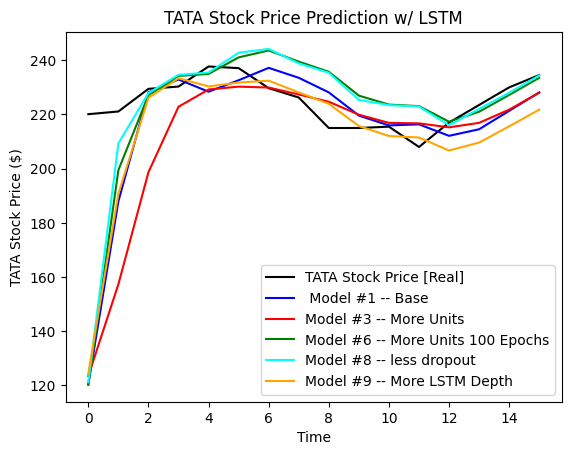

In [57]:
# Plot Results
plt.plot(real_stock_price, color = 'k', label='TATA Stock Price [Real] ')
plt.plot(predicted_stock_price, color = 'b', label = ' Model #1 -- Base ')
#plt.plot(predicted_stock_2, color = 'g', label = ' Model #2 -- Less Epoch')
plt.plot(predicted_stock_3, color = 'r', label = 'Model #3 -- More Units')
# plt.plot(predicted_stock_4, color = 'orange', label = 'Model #4 -- Less Dropout')
#plt.plot(predicted_stock_5, color = 'cyan', label = ' Model #5 -- More Layer')
plt.plot(predicted_stock_6, color = 'green', label = 'Model #6 -- More Units 100 Epochs')
# plt.plot(predicted_stock_7, color = 'cyan', label = ' Model #7 -- Model 6 + More Dropout')
plt.plot(predicted_stock_8, color = 'cyan', label = 'Model #8 -- less dropout')
plt.plot(predicted_stock_9, color = 'orange', label = 'Model #9 -- More LSTM Depth')

plt.title('TATA Stock Price Prediction w/ LSTM')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price ($)')
plt.legend()
plt.show();